# Method 2

Extracting plane polygon based on the segmented roof plane point clouds, then organize them as 3D roof structures

### Imported libraries

In [1]:
import os
import numpy as np
import laspy as lp
import open3d as o3d
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from mpl_toolkits.mplot3d.art3d import Poly3DCollection




### Data 


In [2]:
pointcloud_data = "sample_roofdata_50"
footprint_data = "cropped_data/clipped_final_area.shp"

### 3D models 

In [ ]:

for roof in os.listdir(pointcloud_data):
    if roof.endswith(".laz"):
        file_path = os.path.join(pointcloud_data, roof)
        
        with lp.open(file_path, laz_backend=lp.LazBackend) as fh:
            las_data = fh.read()
            x = las_data.x
            y = las_data.y
            z = las_data.z
            r = las_data.red
            g = las_data.green
            b = las_data.blue
            
            if np.max(r) > 255:  # If 16-bit, convert to 8-bit
                r = r / 65535
                g = g / 65535
                b = b / 65535
            else:  # If already 8-bit
                r = r / 255
                g = g / 255
                b = b / 255

            colors = np.vstack((r, g, b)).T  # (N,3) array
            points = np.vstack((las_data.x, las_data.y, las_data.z)).T  #(N,3) array

            #planar patch detection
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(points)
            pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=30))
            assert (pcd.has_normals())
            oboxes = pcd.detect_planar_patches(
                normal_variance_threshold_deg=15,
                coplanarity_deg=50,
                outlier_ratio=5,
                min_plane_edge_length=3,
                min_num_points=0,
                search_param=o3d.geometry.KDTreeSearchParamKNN(knn=50)
                )

            print("Detected {} patches".format(len(oboxes)))

            geometries = []
            for obox in oboxes:
                mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(obox)
                mesh.paint_uniform_color(obox.color)
                geometries.append(mesh)
                geometries.append(obox)
            geometries.append(pcd)
            
            o3d.visualization.draw_geometries(geometries,
                                              zoom=0.62,
                                  )
            break
            

print("geometries", geometries)

Detected 2 patches
Detected 2 patches
Detected 2 patches
Detected 5 patches
Detected 3 patches
Detected 2 patches
Detected 4 patches
Detected 6 patches
Detected 7 patches
Detected 6 patches


In [3]:
buildings = gpd.read_file(footprint_data)
buildings = buildings.to_crs(25832)

#Get corners from buildings
def extract_corners(polygon):
    if polygon.geom_type == "Polygon":
        return [Point(x, y) for x, y in polygon.exterior.coords] 
    elif polygon.geom_type == "MultiPolygon":
        return [Point(x, y) for poly in polygon.geoms for x, y in poly.exterior.coords] 
    else:
        return None  

buildings["corners"] = buildings["geometry"].apply(extract_corners)

buildings = buildings.to_crs(25832)
buildings.head()

,osm_id,code,fclass,name,type,geometry,corners
0,5079678,1500,building,Trondheim rådhus,public,"POLYGON ((569712.622 7034071.974, 569716.694 7...","[POINT (569712.6216782562 7034071.974002578), ..."
1,17693566,1500,building,Donjon,None,"POLYGON ((570407.846 7033920.271, 570393.136 7...","[POINT (570407.8464293351 7033920.2707800865),..."
2,19145582,1500,building,Trondheim døvekirke,church,"POLYGON ((569828.869 7032858.683, 569829.349 7...","[POINT (569828.8686698809 7032858.682878285), ..."
3,22811509,1500,building,Byåsen butikksenter,retail,"POLYGON ((567499.029 7032887.369, 567499.389 7...","[POINT (567499.0288805708 7032887.368571803), ..."
4,22915083,1500,building,Bunnpris & Gourmet Tyholt,retail,"POLYGON ((571438.583 7033094.082, 571441.699 7...","[POINT (571438.5825759375 7033094.081795346), ..."


In [ ]:
#Adds roofs to a GeoDataFrame

roof_geometries = []
geometries = []

for roof in os.listdir(pointcloud_data):
    if roof.endswith(".laz"):
        file_path = os.path.join(pointcloud_data, roof)
        
        with lp.open(file_path, laz_backend=lp.LazBackend) as fh:
            las_data = fh.read()
            x = las_data.x
            y = las_data.y
            z = las_data.z
            r = las_data.red
            g = las_data.green
            b = las_data.blue
            max_z = np.max(z)
            min_z = np.min(z)
            

            #Normalize RGB values to [0,1]
            if np.max(r) > 255:  # If 16-bit, convert to 8-bit
                r = r / 65535
                g = g / 65535
                b = b / 65535
            else:  # If already 8-bit
                r = r / 255
                g = g / 255
                b = b / 255

            colors = np.vstack((r, g, b)).T  #(N,3)
            points = np.vstack((las_data.x, las_data.y, las_data.z)).T  # (N,3) array

            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(points)
            pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=30))
            assert (pcd.has_normals())

            oboxes = pcd.detect_planar_patches(
                normal_variance_threshold_deg=15,
                coplanarity_deg=50,
                outlier_ratio=5,
                min_plane_edge_length=3,
                min_num_points=0,
                search_param=o3d.geometry.KDTreeSearchParamKNN(knn=50))

            print("Detected {} patches".format(len(oboxes)))

            for obox in oboxes:
                mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(obox)
                mesh.paint_uniform_color(obox.color)
                geometries.append(mesh)
                geometries.append(obox)
                center = obox.get_center()
            geometries.append(pcd)
            center_point = Point(float(center[0]), float(center[1])) 
                 
            o3d.visualization.draw_geometries(geometries,
                                              zoom=0.62,
                                  )
            roof_geometries.append({
                'roof_id': roof,  
                'x': x,
                'y': y,
                'z': z,
                "min_z": min_z,
                "max_z": max_z,
                'NumberOfCorners': geometries[0],
                'center_point' : center_point,
                'Polygon': geometries,
            })

            gdf_roofs = gpd.GeoDataFrame(roof_geometries)
            

gdf_roofs = gdf_roofs.set_geometry("center_point")
gdf_roofs = gdf_roofs.set_crs(25832)
gdf_roofs.head()

print(gdf_roofs["Polygon"])       

Detected 2 patches
Detected 2 patches


2025-03-20 15:37:15.396 Python[64668:2705323] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-20 15:37:15.396 Python[64668:2705323] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Detected 2 patches
Detected 5 patches


In [1]:

for idx, row in gdf_roofs.iterrows():
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for geom in row["Polygon"]:
        if isinstance(geom, o3d.geometry.TriangleMesh):
            vertices = np.asarray(geom.vertices)
            triangles = np.asarray(geom.triangles)

            mesh_tris = [vertices[tri] for tri in triangles]
            color = np.asarray(geom.vertex_colors[0])  # (R,G,B) fra open3d
            face_colors = np.repeat([color], len(mesh_tris), axis=0)

            poly3d = Poly3DCollection(mesh_tris, facecolors=face_colors, edgecolor='k', linewidth=0.1, alpha=1.0)
            ax.add_collection3d(poly3d)



    ax.set_title(f"Roof ID: {row['roof_id']}")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_zlabel("Height (z)")

    plt.tight_layout()
    plt.show()
    break
    

NameError: name 'gdf_roofs' is not defined

In [ ]:
# dataframe where buildings is connected with the nearest roof
buildings = buildings.to_crs(25832)
gdf_roofs = gdf_roofs.to_crs(25832)

combined_footprint_pointcloud: gpd.GeoDataFrame = buildings.sjoin_nearest(gdf_roofs, how="inner", distance_col="distance", max_distance=5)
combined_footprint_pointcloud.head()



,osm_id,code,fclass,name,type,geometry,corners,index_right,roof_id,x,y,z,min_z,max_z,NumberOfCorners,Polygon,distance
613,88741098,1500,building,None,apartments,"POLYGON ((571529.347 7033635.693, 571523.957 7...","[POINT (571529.3473394269 7033635.6930558225),...",21,182218669.laz,"[571508.52, 571508.77, 571507.96, 571507.77, 5...","[7033636.95, 7033638.86, 7033637.28, 7033636.9...","[121.46000000000001, 122.71000000000001, 121.4...",120.45,124.41,TriangleMesh with 8 points and 12 triangles.,"[TriangleMesh with 8 points and 12 triangles.,...",0.0
1686,92541260,1500,building,None,dormitory,"POLYGON ((571823.643 7030638.691, 571815.296 7...","[POINT (571823.6430467416 7030638.691287659), ...",13,10529360.laz,"[571809.08, 571808.8200000001, 571810.27, 5718...","[7030645.3, 7030644.79, 7030646.4, 7030645.83,...","[112.75, 113.11, 111.59, 112.01, 112.41, 112.8...",109.02,113.44,TriangleMesh with 8 points and 12 triangles.,"[TriangleMesh with 8 points and 12 triangles.,...",0.0
1693,92541276,1500,building,None,dormitory,"POLYGON ((571787.495 7030817.551, 571779.008 7...","[POINT (571787.4947625296 7030817.551316508), ...",43,10519144.laz,"[571772.5, 571773.53, 571773.23, 571772.9, 571...","[7030823.95, 7030824.850000001, 7030824.26, 70...","[107.32000000000001, 106.26, 106.7100000000000...",102.89,107.43,TriangleMesh with 8 points and 12 triangles.,"[TriangleMesh with 8 points and 12 triangles.,...",0.0
1704,92541303,1500,building,None,dormitory,"POLYGON ((571837.292 7030653.61, 571829.168 70...","[POINT (571837.292356042 7030653.609804269), P...",23,10529379.laz,"[571833.8200000001, 571833.54, 571833.36, 5718...","[7030650.05, 7030649.51, 7030650.53, 7030650.0...","[112.34, 112.73, 112.37, 112.75, 112.600000000...",108.81,113.31,TriangleMesh with 8 points and 12 triangles.,"[TriangleMesh with 8 points and 12 triangles.,...",0.0
1924,93263988,1500,building,None,garage,"POLYGON ((570544.759 7032122.435, 570536.043 7...","[POINT (570544.7588771572 7032122.435490493), ...",32,182314838.laz,"[570535.52, 570535.28, 570536.48, 570536.05, 5...","[7032128.15, 7032127.69, 7032128.51, 7032127.6...","[72.39, 72.53, 72.26, 72.5, 72.64, 72.8, 72.24...",72.09,73.32,TriangleMesh with 8 points and 12 triangles.,"[TriangleMesh with 8 points and 12 triangles.,...",0.0


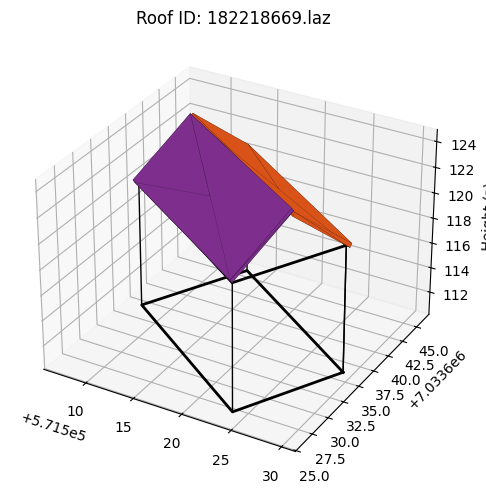

In [ ]:

for idx, row in combined_footprint_pointcloud.iterrows():
    geometry = row["geometry"]  
    points_x = row["x"]  
    points_y = row["y"] 
    points_z = row["z"]  
    min_z = row["min_z"]
    max_z = row["max_z"]
   

    if geometry is not None and geometry.geom_type == "Polygon":
        x_fkb, y_fkb = geometry.exterior.xy  
        corners = [Point(x, y) for x, y in geometry.exterior.coords]
        corner_x = [point.x for point in corners]
        corner_y = [point.y for point in corners]
        max_z = np.max(points_z) 


        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection="3d")
        ax.plot(x_fkb, y_fkb, zs=min_z-10, color="black", linewidth=2)
        ax.plot(x_fkb, y_fkb, zs=min_z, color="black", linewidth=2)

        for x, y in zip(corner_x, corner_y):
            ax.plot([x, x], [y, y], [min_z-10, min_z], color="black", linewidth=1)

    for geom in row["Polygon"]:
        if isinstance(geom, o3d.geometry.TriangleMesh):
            vertices = np.asarray(geom.vertices)
            triangles = np.asarray(geom.triangles)

            mesh_tris = [vertices[tri] for tri in triangles]
            color = np.asarray(geom.vertex_colors[0]) 
            face_colors = np.repeat([color], len(mesh_tris), axis=0)

            poly3d = Poly3DCollection(mesh_tris, facecolors=face_colors, edgecolor='k', linewidth=0.1, alpha=1.0)
            ax.add_collection3d(poly3d)

    ax.set_title(f"Roof ID: {row['roof_id']}")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_zlabel("Height (z)")

    plt.tight_layout()
    plt.show()
    break
    